The goal of this project is to build and evaluate a system capable of **distinguishing** between real and deep fake faces using pre-trained neural networks. This system is intended to provide a robust approach to identifying AI-generated images, which is crucial given the growing prevalence of deep fake technologies.

Deep fake images and videos have raised concerns across various domains, including cybersecurity, media authenticity, and personal privacy. The development of reliable detection techniques is essential to mitigate their misuse. This project explores the performance of pre-trained models such as *ResNet*, *EfficientNet*, *DenseNet* and *Vision Transformer* (ViT) for this task.

# Dataset Description



The dataset used in this project contains images of real faces and deep fake faces, organized into two main categories:

1. **Real Faces**: These images are stored in folders prefixed with "0-".

2. **DeepFake Faces**: These images are stored in folders prefixed with "1-".

Each image represents a human face, with the deep fake images generated using advanced artificial intelligence techniques such as StyleGAN or StyleGAN2, which are widely used for generating synthetic facial images. The real face images come from publicly available high-quality datasets containing photographs of authentic human faces.



In [23]:
zip_path = '/content/drive/MyDrive/deepfake_dataset/zip_file/'
dataset_path = '/content/drive/MyDrive/deepfake_dataset/portioned/'

# Function to extract the images in the right subfolder
def extract_zip(file_path, output_path):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

files_to_extract = ['0-CelebA.zip', '0-FFHQ.zip', '1-ATTGAN.zip', '1-GDWCT.zip', '1-StarGAN.zip', '1-STYLEGAN.zip', '1-STYLEGAN2.zip']

for file in files_to_extract:
    # 0 for real and 1 for fake
    label = file.split('-')[0]  #take the prefix to base the coiche

    if label == '0':
        target_folder = '0_real'
    else:
        target_folder = '1_fake'

    # Creates the full path to the destination folder
    output_path = os.path.join(dataset_path, target_folder)
    folder = os.path.join(dataset_path, target_folder,file.replace('.zip', ''))

    # Check if the file has already been extracted
    if not os.path.exists(folder):
        os.makedirs(output_path, exist_ok=True)
        extract_zip(os.path.join(zip_path, file), output_path)
        print(f"{file} extracted in {output_path}.")
    else:
        print(f"{file} already extracted")

print("All files are processed.")

0-CelebA.zip already extracted
0-FFHQ.zip already extracted
1-ATTGAN.zip already extracted
1-GDWCT.zip already extracted
1-StarGAN.zip already extracted
1-STYLEGAN.zip already extracted
1-STYLEGAN2.zip already extracted
All files are processed.


After mounting Google Drive on Colab to seamlessly access the dataset without overloading Colab's memory, I extracted the zip files containing the images, organized based on their creation method. I structured the dataset into two main folders: *Real* and *Fake*.

Before diving into data preprocessing, I explored an intriguing step: transitioning these images from the spatial domain to the frequency domain using the two-dimensional Fourier transform. This approach allowed me to investigate whether images generated by certain models exhibit recurring patterns or atypical structures.

To achieve this, I transformed each image into its frequency domain representation, calculated the average frequency spectrum for each folder, and then computed the overall averages for both Real and Deep Fake images. This analysis serves as a foundation to uncover unique traits within each category.

Further details will be discussed in the next section.

## Fourier Spectra of the Images

In the context of analyzing images, the **spatial domain** alone may not reveal subtle differences. Generative models like GANs often produce images that visually resemble real ones but exhibit *distinctive patterns* in their underlying frequency distributions.

The Fourier Transform provides a way to examine these frequency characteristics. By converting images from the spatial domain to the **frequency domain**, we can uncover artifacts introduced by generative models, differences in energy distribution, insights into the generative process.

This makes Fourier analysis a powerful tool for understanding and comparing the properties of real and fake images beyond their appearance, making it an essential choice for this study.

The 2D Fourier Transform is a fundamental tool for analyzing the spatial frequencies of an image. When applied to an image:

* **Low frequencies** (*near the center of the spectrum*): correspond to slow variations (large structures or smooth gradients).

* **High frequencies** (*near the edges of the spectrum*): correspond to fine details or rapid variations (textures or sharp edges).

The result of the transform is an amplitude spectrum, representing the energy of the spatial frequencies present in the image. In the visualization the bright central region represents the dominance of low frequencies (typical in natural images).
Regular or symmetric patterns indicate artifacts, often associated with synthetic images.

The Fourier Transform is particularly useful for analyzing differences between real and artificially generated images. Generative models, such as GANs (Generative Adversarial Networks), often introduce artifacts at specific frequencies, which can be identified in the spectrum.


In [24]:
f_celeb = mean_fourier(image_folder='/content/drive/MyDrive/deepfake_dataset/portioned/0_real/0-CelebA', image_format="*.jpg", resize_dim=(224,224))

f_ffhq = mean_fourier(image_folder='/content/drive/MyDrive/deepfake_dataset/portioned/0_real/0-FFHQ', resize_dim=(224,224))

f_attgan = mean_fourier(image_folder='/content/drive/MyDrive/deepfake_dataset/portioned/1_fake/1-ATTGAN', resize_dim=(224,224))

f_gdwct = mean_fourier(image_folder='/content/drive/MyDrive/deepfake_dataset/portioned/1_fake/1-GDWCT', resize_dim=(224,224))

f_stargan = mean_fourier(image_folder='/content/drive/MyDrive/deepfake_dataset/portioned/1_fake/1-StarGAN', resize_dim=(224,224))

f_stylegan = mean_fourier(image_folder='/content/drive/MyDrive/deepfake_dataset/portioned/1_fake/1-STYLEGAN',image_format="*.jpg", resize_dim=(224,224))

f_stylegan2 = mean_fourier(image_folder='/content/drive/MyDrive/deepfake_dataset/portioned/1_fake/1-STYLEGAN2', resize_dim=(224,224))

In [25]:
output_folder = "/content/drive/MyDrive/deepfake_dataset/fourier"
os.makedirs(output_folder, exist_ok=True)

real_fourier = [f_celeb, f_ffhq]
fake_fourier = [f_attgan, f_gdwct, f_stargan, f_stylegan, f_stylegan2]
f_real = np.mean([f for f in real_fourier if f is not None], axis=0)
f_fake = np.mean([f for f in fake_fourier if f is not None], axis=0)

fourier_data = {
    "0-CelebA (Real)": f_celeb,
    "0-FFHQ (Real)": f_ffhq,
    "1-ATTGAN (Fake)": f_attgan,
    "1-GDWCT (Fake)": f_gdwct,
    "1-StarGAN (Fake)": f_stargan,
    "1-STYLEGAN (Fake)": f_stylegan,
    "1-STYLEGAN2 (Fake)": f_stylegan2,
    "0_Real": f_real,
    "1_fake": f_fake
}

# save each fourier like an image
for title, data in fourier_data.items():
    if data is not None:
        # generate the name of the file
        file_name = f"{title.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')}.png"
        save_path = os.path.join(output_folder, file_name)

        # check for the existence of the file
        if not os.path.exists(save_path):
            plt.figure(figsize=(6, 6))
            plt.imshow(np.log1p(data), cmap="viridis")
            plt.title(title, fontsize=12)
            plt.axis("off")

            # save
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Saved: {save_path}")
        else:
            print(f"File already exists, skipping: {file_name}")

File already exists, skipping: 0_CelebA_Real.png
File already exists, skipping: 0_FFHQ_Real.png
File already exists, skipping: 1_ATTGAN_Fake.png
File already exists, skipping: 1_GDWCT_Fake.png
File already exists, skipping: 1_StarGAN_Fake.png
File already exists, skipping: 1_STYLEGAN_Fake.png
File already exists, skipping: 1_STYLEGAN2_Fake.png
File already exists, skipping: 0_Real.png
File already exists, skipping: 1_fake.png


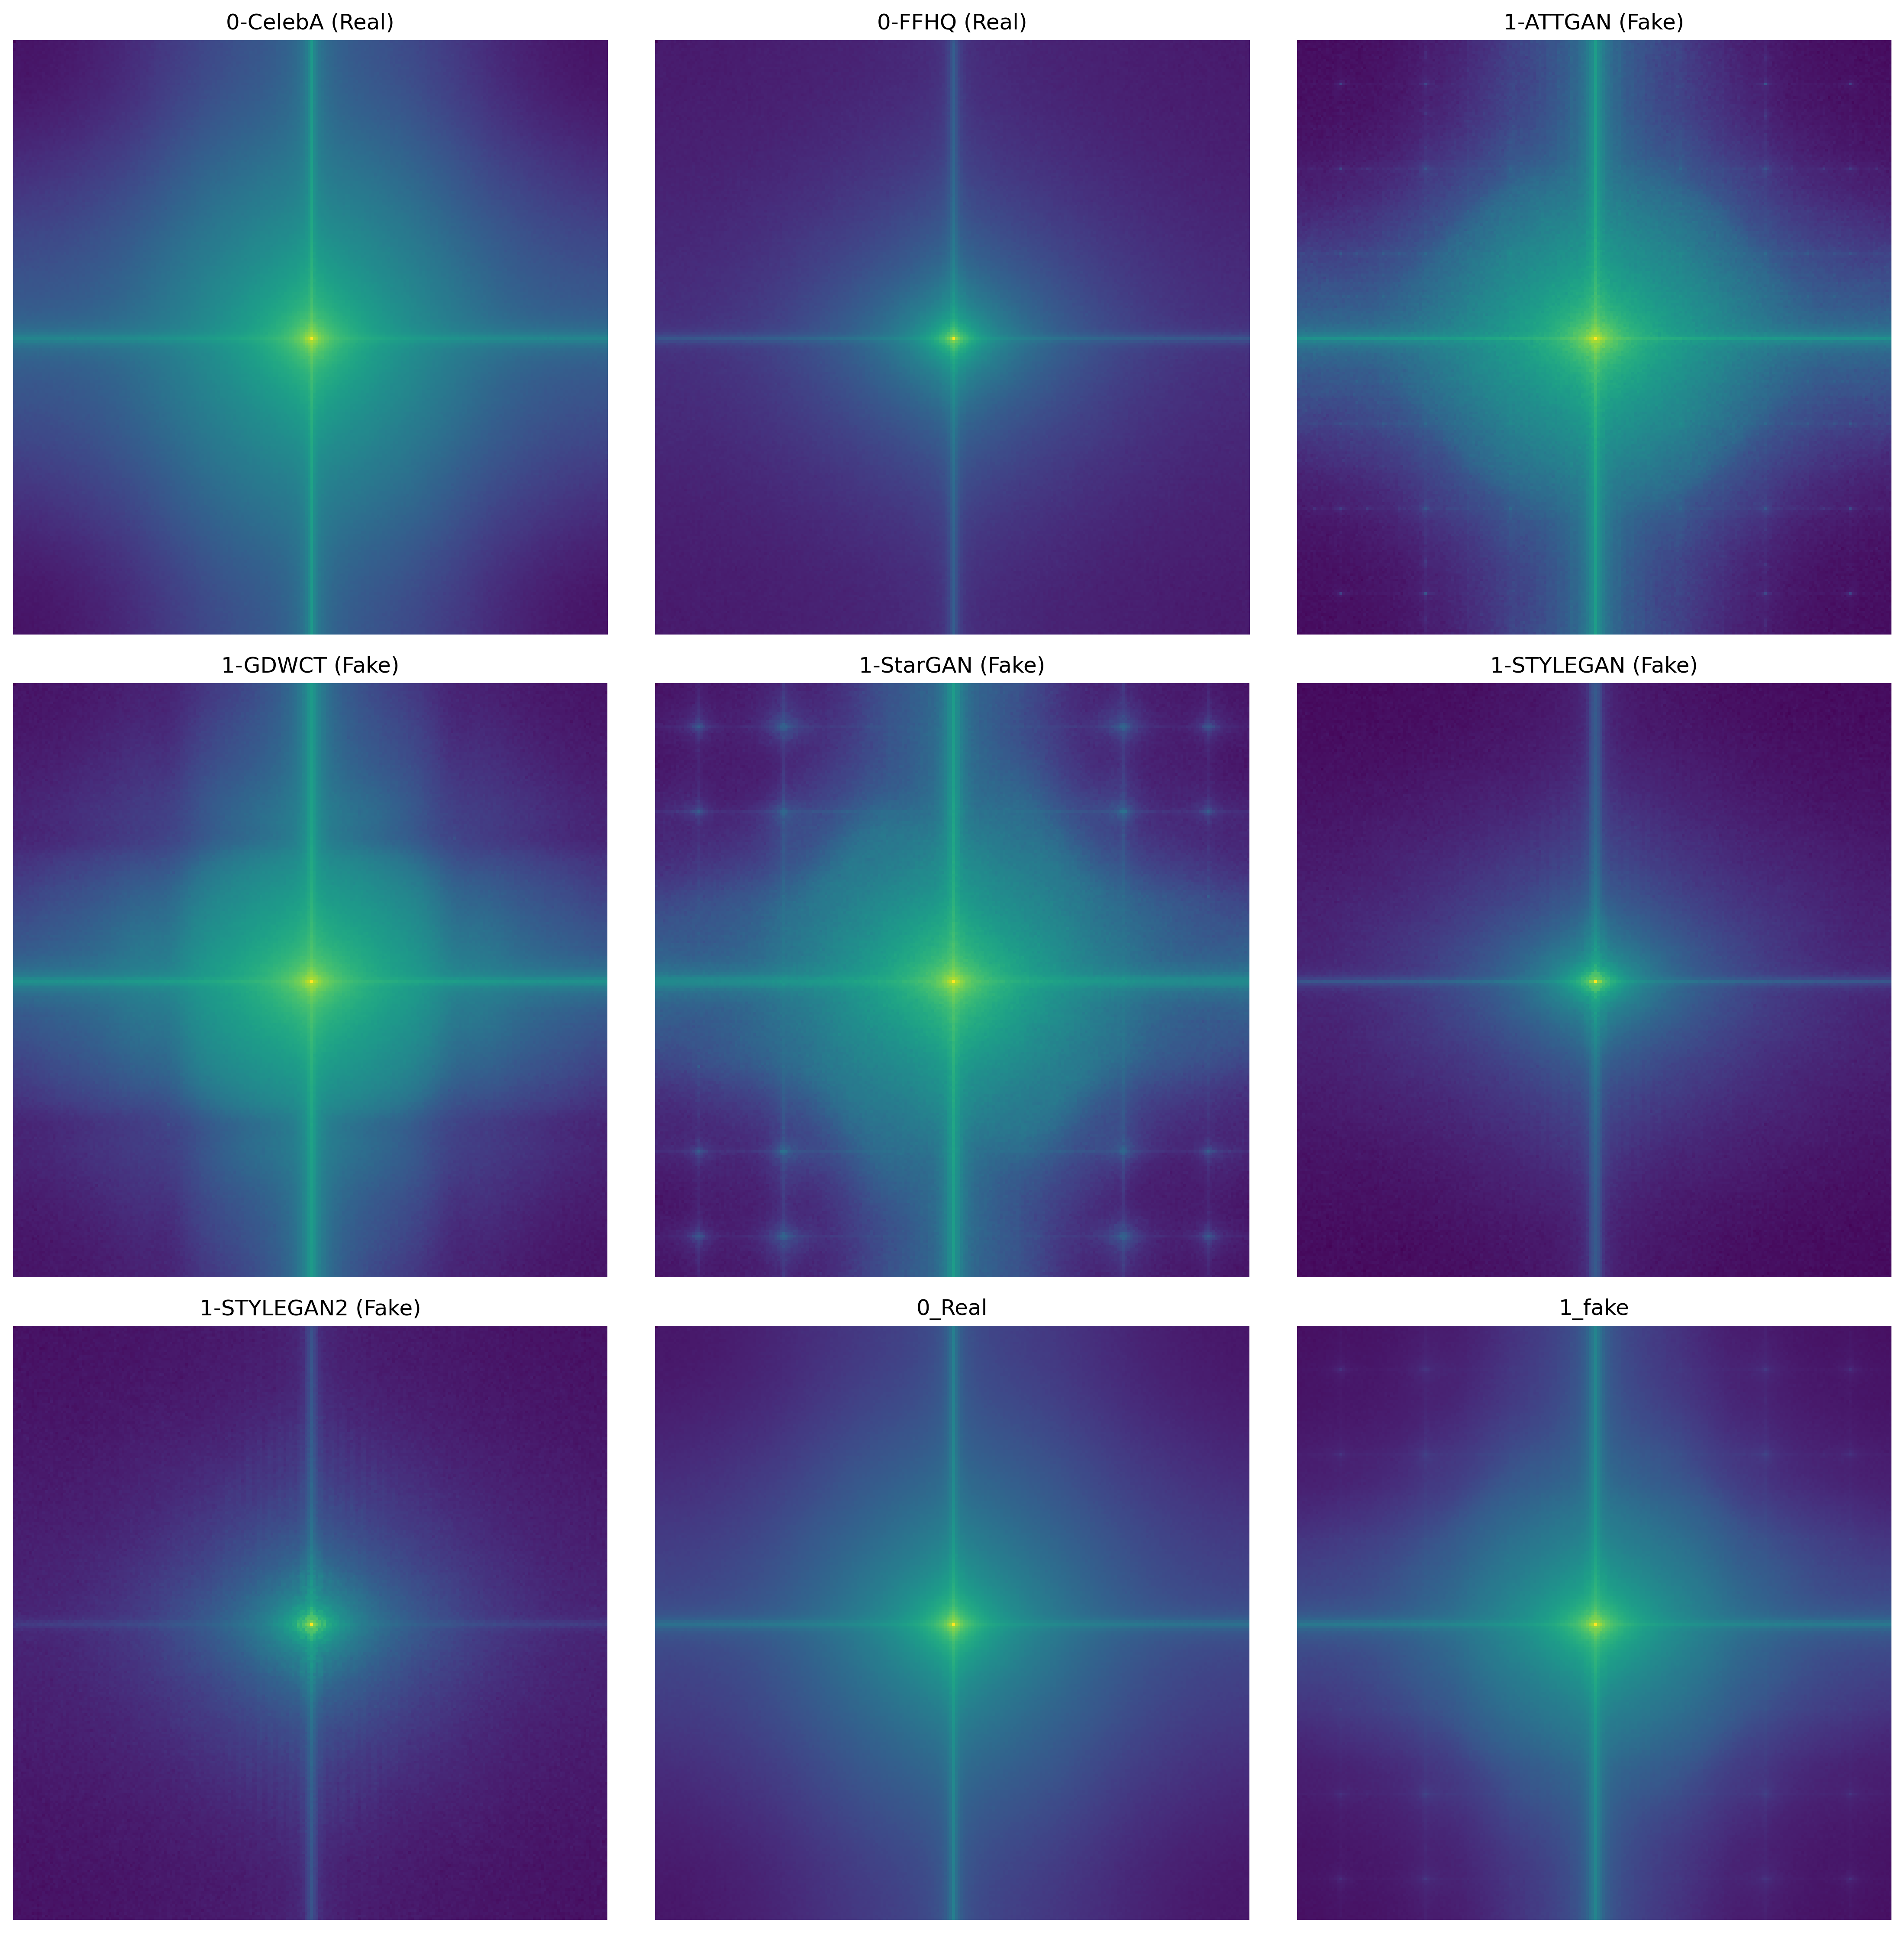

In [31]:
show_fourier()

Now, let's delve into the results obtained:

1. **Real Images** (*CelebA, FFHQ*):
The spectra exhibit a **dominant central peak** with a gradual decay toward higher frequencies. These spectra are typical of natural images, where low frequencies dominate due to the spatial coherence of structures. **No periodic or symmetric patterns are observed**, indicating the absence of artificial artifacts in the data.

2. **Synthetic Images** (*ATTGAN, GDWCT, StarGAN, STYLEGAN*):

  * ATTGAN and GDWCT: Show less pronounced **regular patterns** but still exhibit some periodic structures, indicating artifacts introduced by the generative process.
  * StarGAN and STYLEGAN: Display clear **grid-like patterns** and pronounced symmetries, with visible periodic frequencies.

These artifacts are characteristic of GAN models, which tend to introduce unwanted frequencies during the image generation process. These patterns may stem from the convolutional operations in the generator.

For a more in-depth consultation, I saved the resulting images on Drive, ensuring they are readily accessible

## Preprocessing

The preprocessing steps were carried out to ensure. The preprocessing steps include:

1. *Resizing*: The images were resized to a consistent size (224x224 pixels), to ensure uniform processing.
2. *Normalization*: To improve convergence during training, the images were normalized by a normalization standard to match the distribution of training data from pre-trained models, such as subtracting the mean and dividing by the standard deviation of the ImageNet dataset.
3. *Augmentation*: To increase the variability of the images and enhance model robustness, augmentation techniques were applied, including rotation, translation, horizontal flipping, and brightness adjustments, to generate different versions of the images for training.

The dataset was divided into three subsets:



*   *Training Set*: Used to train the deep learning models. About 70% of the images were allocated to training.
*   *Validation Set*: Used to fine-tune model parameters and prevent overfitting. About 15% of the images were allocated to validation.
*  *Test Set*: Used to evaluate the model’s generalization capability on unseen data. About 15% of the images were allocated to testing.

This split allows for evaluating the model’s effectiveness during and after training, ensuring there is no bias and that the model can generalize well to new images.

In [34]:
data_dir = '/content/drive/MyDrive/deepfake_dataset/portioned/'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images
    transforms.ToTensor(),  # Convert the images in tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#normalization
])

# Upload the dataset (each folder divided by label)
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print(f"Class: {class_names}")
print()

# element of each class
class_counts = Counter(dataset.targets)
class_names = dataset.classes
for class_idx, count in class_counts.items():
    print(f"Classe '{class_names[class_idx]}': {count} immages")
print()

#(80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# dataLoader for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=2,pin_memory=True)

print(f"Number of images the training set: {len(train_dataset)}")
print(f"Number of images in the validation set: {len(val_dataset)}")

Class: ['0_real', '1_fake']

Classe '0_real': 1000 immages
Classe '1_fake': 1000 immages

Number of images the training set: 1600
Number of images in the validation set: 400


# Methodology

The following pre-trained models were selected for this project due to their proven effectiveness in image classification tasks:

`DenseNet-121`: This model is known for its efficient architecture that allows each layer to receive input from all previous layers, facilitating better feature reuse and leading to improved performance with fewer parameters. The number 121 refers to the number of layers in the network, striking a balance between model complexity and computational efficiency.

`ResNet-18`: ResNet (Residual Networks) are designed to combat the vanishing gradient problem by using residual connections, allowing for very deep networks without a significant loss in performance. The "18" refers to the number of layers in the network, which is the smallest version of ResNet, making it ideal for tasks where computational resources or training data are limited.

`EfficientNet-B0`: This model uses a novel compound scaling method that scales depth, width, and resolution uniformly, providing state-of-the-art accuracy with fewer parameters and lower computational cost. EfficientNet has multiple variants (e.g., EfficientNet-B0, B1, etc.), with the number indicating the model size. The larger the number, the more computationally intensive and accurate the model becomes. For this project, the B0 variant was selected based on the available resources and required performance.

`Vision Transformer` (`ViT`): ViT leverages transformer architectures, which have demonstrated remarkable performance in vision tasks by processing image patches as sequences, similar to how text is processed in NLP tasks. This model is known for its scalability and performance on large datasets.

These models were selected for their ability to generalize well on image classification tasks, as well as their diverse architectural characteristics, which help explore different approaches to the problem.

# Training Process

The training process was designed to ensure efficient model learning while preventing overfitting and handling limited GPU memory. The following key steps were implemented.

## Training Setup

Loss Function (Criterion): The CrossEntropyLoss was used as the criterion to evaluate the model's performance during training and validation. This loss function is commonly used for multi-class classification tasks, which aligns with the binary classification problem of distinguishing real and deep fake faces.

Optimizer: The Adam optimizer was chosen due to its adaptive learning rate capabilities, which help in faster convergence and stability during training. The learning rate was set to 1e-4, a commonly used value for fine-tuning pre-trained models.

Learning Rate Scheduler: The ReduceLROnPlateau scheduler was implemented to reduce the learning rate if the validation loss plateaus, helping to refine the model's training by providing smaller updates when necessary. This helps avoid overshooting the optimal weights as the model approaches convergence.

## Training Loop

The train_one_epoch function handles the training for each epoch. For each batch of images, the model performs the following:

Forward Pass: The input images are passed through the model to generate predictions.

Loss Calculation: The model's predictions are compared with the true labels using CrossEntropyLoss, which is computed for the batch.

Gradient Accumulation: To simulate larger batch sizes while maintaining memory efficiency, the loss is divided by the accumulation_steps (set to 4 in this case). Gradients are accumulated over several mini-batches, and the model's weights are updated only after accumulating gradients for accumulation_steps mini-batches.

Accuracy Tracking: The training accuracy is calculated by comparing the model's predictions with the true labels.
The validate_one_epoch_with_preds function is used for validating the model at the end of each epoch:

Forward Pass: Like the training phase, the model generates
predictions for the validation dataset.

Loss and Accuracy Calculation: The loss and accuracy are computed for the entire validation set.

Metrics Tracking: The true labels and predicted labels are stored to calculate additional evaluation metrics (precision, recall, F1-score).

## Evaluation Metrics


To monitor the model's performance during training, the following metrics were computed:

Accuracy: Measures the percentage of correct predictions in both training and validation sets.

Precision, Recall, and F1-Score: These metrics are calculated for the validation set to assess the classifier's ability to correctly identify real and deep fake faces, considering both false positives and false negatives.

Confusion Matrix: The confusion matrix was computed at the end of each epoch, providing a clear visualization of the model's classification performance, including true positives, false positives, true negatives, and false negatives.

## Optimization Techniques

To improve model training, the following techniques were employed:

Early Stopping: To prevent overfitting and unnecessary computation, early stopping was implemented. If the validation loss does not improve after a specified number of epochs (set to patience=3), training stops early.

Batch Accumulation: Given the constraints on GPU memory, batch accumulation was used to simulate larger batch sizes. This technique allows for more effective weight updates without exceeding memory limits, enabling the use of deeper and more complex models.

## Model Evaluation and Saving Results


Best Model Selection: The model with the lowest validation loss was saved as the best model. If the validation loss improved during an epoch, the results (precision, recall, F1-score, and confusion matrix) were updated.

Confusion Matrix Visualization: At the end of training, a heatmap of the confusion matrix was generated, providing insights into the model’s classification performance across different classes (real vs. fake faces).

Results Storage: All the results (training and validation losses, accuracies, and metrics for each epoch) were stored in a CSV file for further analysis and visualization.

# The Training

Now, let's start to train each one of the choosen models, all of them with all frozen layers, except for the last one, the Classifier.

## ResNet-18

In [36]:
rn18 = resnet18(weights= ResNet18_Weights.DEFAULT)
rn18.fc = nn.Linear(rn18.fc.in_features, 2)

# Congela tutti i parametri
for param in rn18.parameters():
    param.requires_grad = False

# Sblocca solo l'ultimo layer
for param in rn18.fc.parameters():
    param.requires_grad = True

#Execute Training
criterion, optimizer, scheduler = setup_training(rn18)

rn18_firstTrain = train_model(rn18, "ResNet-18", criterion, optimizer, train_loader=train_loader, val_loader=val_loader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]



Model 'ResNet-18' already exists in /content/drive/MyDrive/deepfake_dataset/models/ResNet-18. Training skipped.


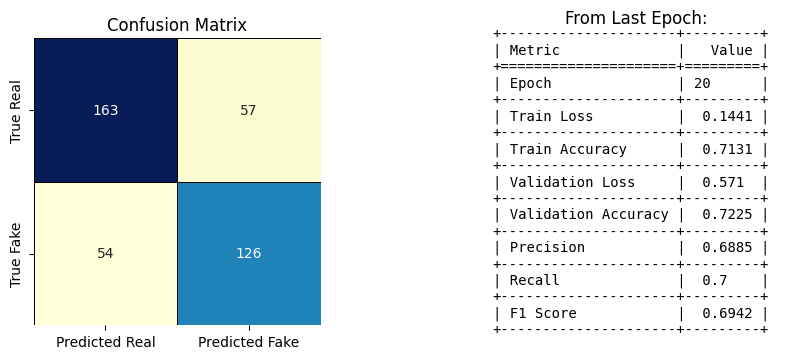

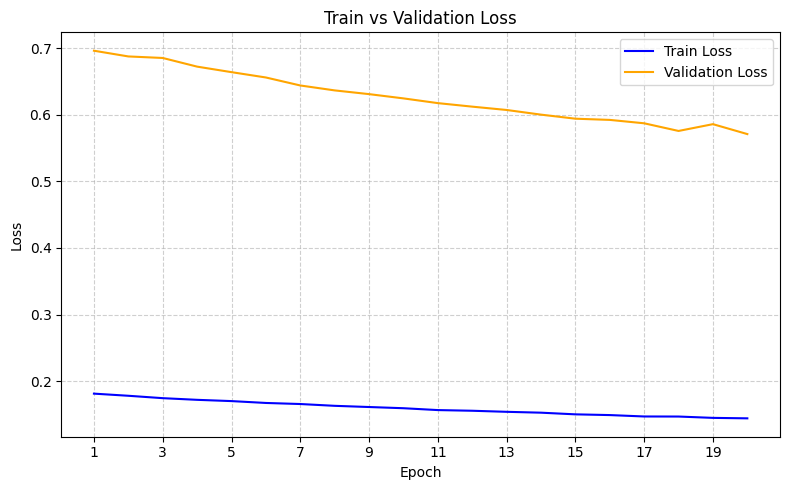

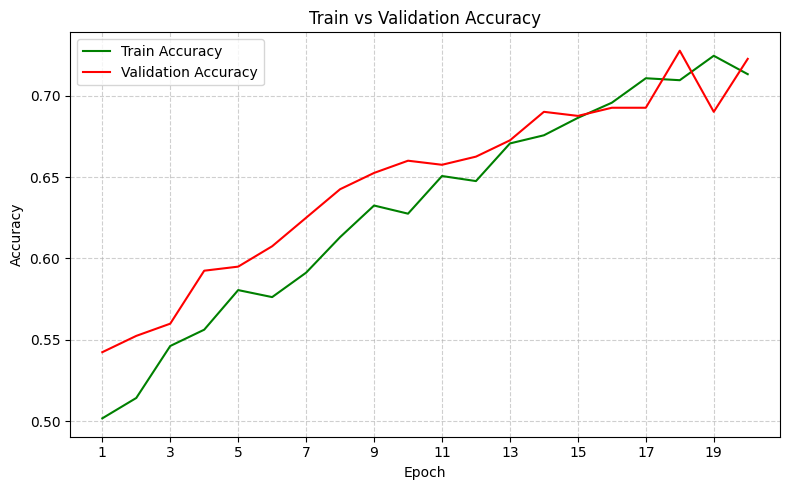

In [37]:
performance("ResNet-18")

The model shows promising results overall, but there are areas where we could see improvement.

The **training loss** is relatively low at `0.1441`, suggesting that the model has learned well from the training data. However, the higher **validation loss** compared to the training loss points to a potential issue of overfitting. This means that while the model performs well on the training set, it might not generalize as well to the validation set.

Looking at the training and validation accuracy, both values are fairly close to each other, which is a positive sign, indicating that the model is not significantly overfitting. The **training accuracy** of `71.31%` and **validation accuracy** of `72.25%` are both respectable, but there’s still room to increase performance.

**Precision** stands at `68.85%`, meaning that when the model predicts a positive class, it is correct nearly 69% of the time. The **Recall** indicate that the model is identifying `70%` of the true positive cases. The F1 score is a combination of these two metrics and reflects a good but improvable balance between them.

In terms of the **confusion matrix**, the model has correctly classified `163 true negatives` and `126 true positives`, which is good. However, there are some errors: `57 false positives` and `54 false negatives`. These errors could be minimized with model tuning, better feature engineering, or even more training data.

## EfficientNet

In [38]:
effnet = efficientnet_b0(weights= EfficientNet_B0_Weights.DEFAULT)
effnet.classifier = nn.Linear(effnet.classifier[1].in_features, 2)

# Congelare tutti i layer tranne l'ultimo
for param in effnet.parameters():
    param.requires_grad = False

# Sbloccare l'ultimo layer (classifier)
for param in effnet.classifier.parameters():
    param.requires_grad = True

#Execute Training
criterion, optimizer, scheduler = setup_training(effnet)

effnet_firstTrain = train_model(effnet, "EfficientNet", criterion, optimizer, train_loader=train_loader, val_loader=val_loader)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


Model 'EfficientNet' already exists in /content/drive/MyDrive/deepfake_dataset/models/EfficientNet. Training skipped.


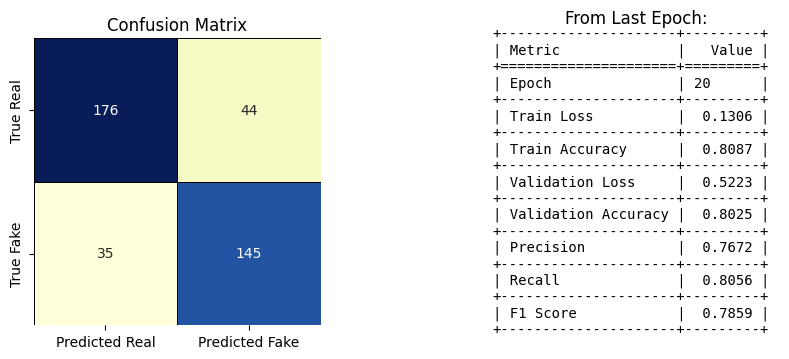

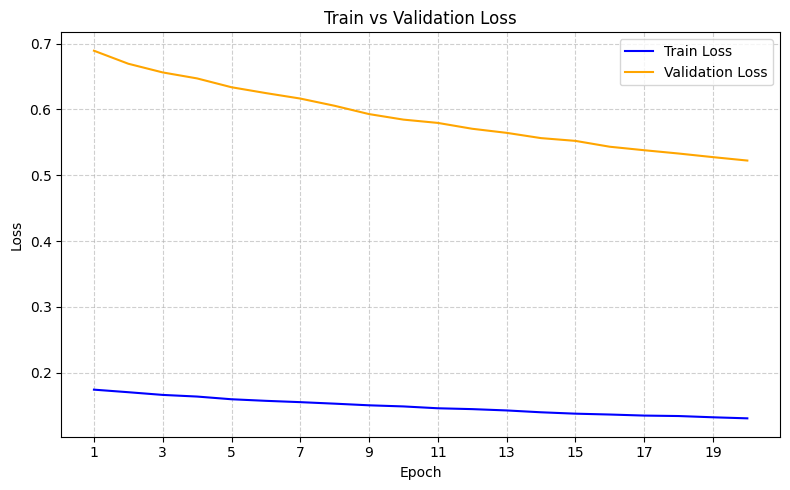

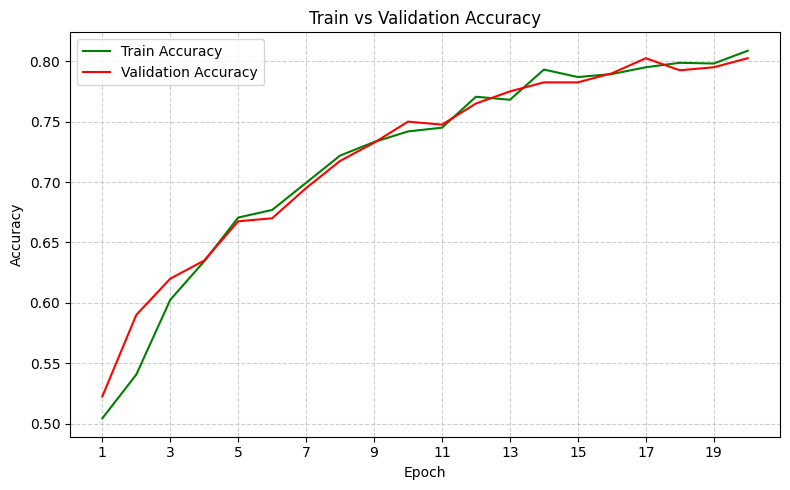

In [39]:
performance("EfficientNet")

The EfficientNet model demonstrates solid performance but leaves room for improvement in some areas.

The **training loss** is relatively low at `0.1306`, indicating that the model has effectively learned patterns from the training data. However, the higher **validation loss** of `0.5223` suggests that the model may be struggling to generalize to unseen data, which could be an indicator of mild overfitting.

When comparing the **training accuracy** of `80.87%` with the **validation accuracy** of `80.25%`, the two values are quite close. This consistency is a positive sign, as it implies that the model is not significantly overfitting.

Looking deeper into the precision, recall, and F1 score:

**Precision** (`76.72%`) shows that when the model predicts a positive class, it is correct nearly 77% of the time.
**Recall** (`80.56%`) highlights that the model is successfully identifying over 80% of the true positive cases.
The **F1 score** (`78.59%`) reflects a strong balance between precision and recall, which is encouraging.

From the confusion matrix, we can see that the model correctly classified:

1. 176 true negatives;
2. 145 true positives;

However, there are notable errors that suggest potential areas for improvement. For instance, reducing false negatives would boost recall, while minimizing false positives would improve precision.

Overall, EfficientNet shows promise with good generalization, but there is still scope for optimization to achieve higher performance.

## DenseNet-121

In [40]:
dn121 = densenet121(weights = DenseNet121_Weights.DEFAULT)
dn121.classifier = nn.Linear(dn121.classifier.in_features, 2)

# Congela tutti i parametri
for param in dn121.parameters():
    param.requires_grad = False

# Sblocca solo l'ultimo layer
for param in dn121.classifier.parameters():
    param.requires_grad = True

#Execute Training
criterion, optimizer, scheduler = setup_training(dn121)
denseNet_firstTrain = train_model(dn121, "DenseNet121", criterion, optimizer, train_loader=train_loader, val_loader=val_loader)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s]


Model 'DenseNet121' already exists in /content/drive/MyDrive/deepfake_dataset/models/DenseNet121. Training skipped.


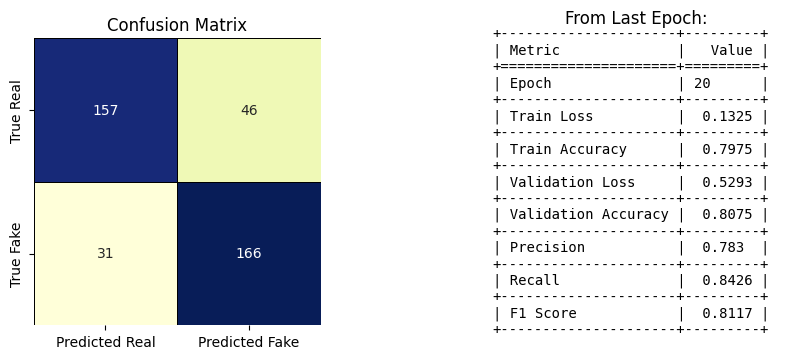

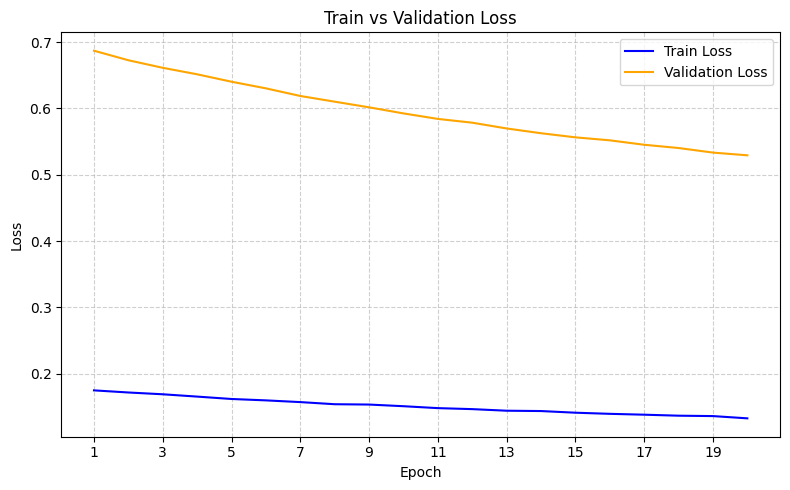

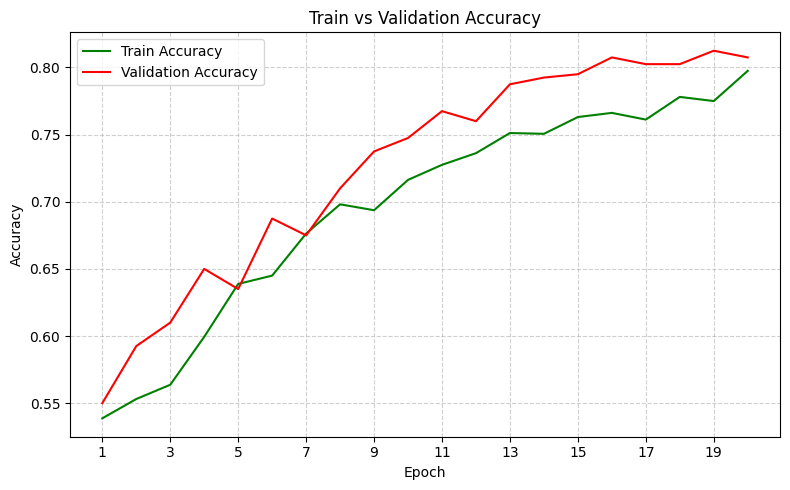

In [41]:
performance("DenseNet121")

The **training loss** is relatively low at `0.1325`, which indicates that the model has successfully learned patterns from the training data. However, the **validation loss** of `0.5293` is higher, suggesting that the model might be struggling to generalize to new, unseen data. This discrepancy between the training and validation losses could point to mild overfitting.

When comparing the **training accuracy** of `79.75%` and the validation accuracy of `80.75%`, the close proximity between the two values suggests that the model is not severely overfitting. This is a positive sign, as it indicates that the model performs similarly on both the training and validation sets.

Looking at precision, recall, and F1 score:

**Precision** (`78.30%`) tells us that when the model predicts a positive class (fake face), it is correct `78.30%` of the time. This is a good result, but there is still room for improvement to reduce false positives (real faces misclassified as fake).

**Recall** (`84.26%`) indicates that the model successfully identifies 84.26% of the true positives (fake faces). This is a strong result, but further improvement could be made by reducing false negatives (fake faces misclassified as real).

The **F1 score** (`81.17%`) reflects a strong balance between precision and recall, indicating that the model has achieved a solid trade-off between these two metrics.

In summary, DenseNet-121 shows good generalization with a strong ability to identify fake faces. However, there is still potential for improvement, particularly in reducing misclassifications, such as false positives and false negatives, to boost both precision and recall. Further optimization can lead to better performance.

## ViT

In [42]:
vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
vit.classifier = nn.Linear(vit.classifier.in_features, 2)

# Congela tutti i parametri
for param in vit.parameters():
    param.requires_grad = False

# Sblocca solo l'ultimo layer
for param in vit.classifier.parameters():
    param.requires_grad = True

#Execute Training
criterion, optimizer, scheduler = setup_training(vit)
vit_firstTrain = train_model(model=vit, model_name="Vit", criterion=criterion, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Model 'Vit' already exists in /content/drive/MyDrive/deepfake_dataset/models/Vit. Training skipped.


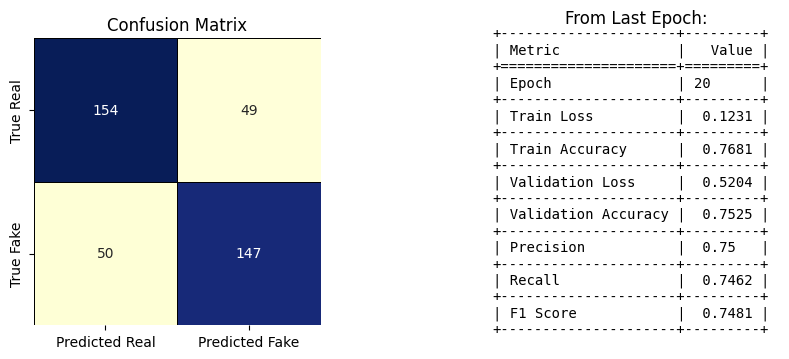

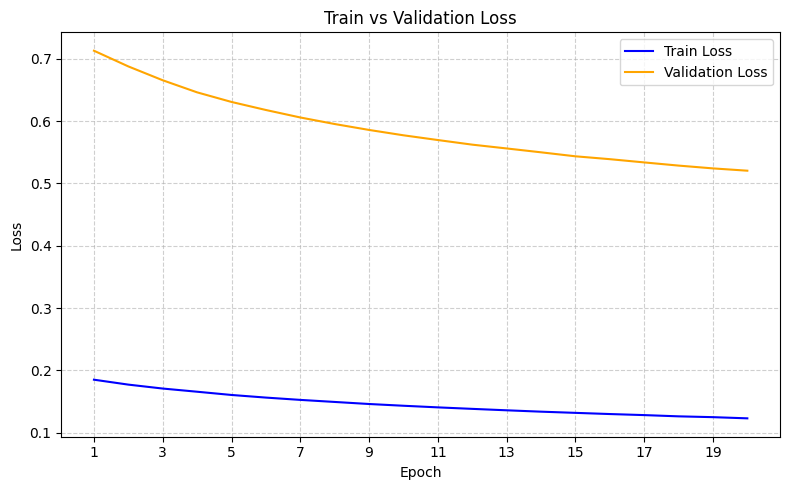

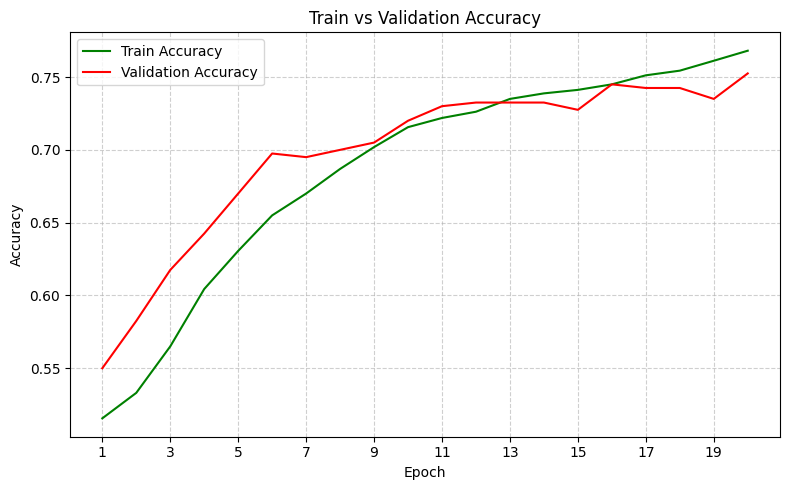

In [43]:
performance("Vit")

The ViT (Vision Transformer) model shows promising results with room for further improvement in some areas.

The **training loss** starts at `0.1851` and decreases to `0.1231` by epoch 20, suggesting that the model effectively learns patterns from the training data. However, the** validation loss** remains higher, starting at `0.7129` and dropping to `0.5204` by epoch 20. While the model’s validation loss decreases over time, it’s still higher than the training loss, indicating some level of overfitting. The model may be performing well on the training data but struggling to generalize to unseen data.

When we look at the **training accuracy**, it increases from `51.56%` in the first epoch to `76.81%` in the final epoch, demonstrating an improvement in the model’s ability to correctly classify the training set. Similarly, the **validation accuracy** starts at `55%` and rises to `75.25%` by epoch 20, showing a consistent improvement.

**Precision** indicates that when the model predicts a positive class (fake face), it is correct `75%` of the time.
The **Recall** highlights that the model identifies `74.62%` of the true positives (fake faces). Although recall is relatively high, further improvements could still reduce the number of false negatives (fake faces misclassified as real).
**F1 score** (`74.81%`) represents a balanced performance between precision and recall, indicating the model’s strength in both correctly identifying fake faces and minimizing misclassifications.

Looking at the **confusion matrix**, The presence of errors suggests areas where the model could be further optimized, specifically by reducing false positives to improve precision and false negatives to enhance recall.

In summary, the ViT model performs well with solid generalization across training and validation sets. While precision, recall, and F1 score are strong, there is still potential to reduce misclassifications, especially false positives and false negatives, through further tuning and optimization.

## The Choice

Now, compare each model to others to choose of them:

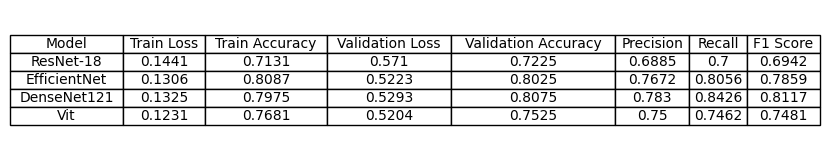

In [44]:
model_names = ['ResNet-18', 'EfficientNet', 'DenseNet121', 'Vit']
recap(model_names)

***EfficientNet*** stands out as an excellent choice, combining high performance with lightweight efficiency. With a **validation accuracy** of `80.25%` and an **F1 score** of `78.59%`, it demonstrates an excellent balance between precision and recall while remaining a lighter model, ideal for resource-constrained applications.

Its slightly higher **precision** (`76.72%`) compared to **DenseNet121** (`78.30%`) makes it particularly suitable for reducing false positives, which is critical in tasks like detecting fake faces where minimizing errors is essential. Additionally, the lowest **validation loss** (`0.5223`) among the models indicates that **EfficientNet** generalizes better on the validation dataset.

While **DenseNet121** offers a slight edge in recall (`84.26%` vs. `80.56%`), its higher computational cost makes it less practical for environments with limited hardware resources or where speed is a key factor. Compared to **ResNet-18** and **ViT**, ***EfficientNet*** clearly outperforms both in accuracy and F1 score, making it the ideal compromise between performance and efficiency.

In summary, ***EfficientNet*** represents the most balanced solution when looking for an efficient yet high-performing model. For applications requiring a lightweight implementation without sacrificing too much in terms of accuracy and overall performance, EfficientNet is the best choice.

# EfficientNet_2 (After Unlocking Layers)

Since EfficientNet has demonstrated commendable results when applied to our dataset, the next logical step is to unfreeze additional layers preceding the classifier. This approach allows us to fine-tune the weights in these layers, which could potentially lead to improved performance. Specifically, I have unfrozen the last two layers of the features block, which is responsible for extracting high-level representations from the input data through a series of convolutional and pooling operations. By fine-tuning these layers, we aim to enhance the model's ability to capture more nuanced patterns in the data.

I would also like to highlight that, while a scheduler has been declared in the function, it is not yet being used. Its inclusion was a strategic choice for scalability, ensuring a smoother implementation in future training phases if needed.

Now, let's start with the traing and see the results.

In [45]:
effnet2 = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
effnet2.classifier = nn.Linear(effnet2.classifier[1].in_features, 2)

for param in effnet2.parameters():
    param.requires_grad = False

for param in effnet2.classifier.parameters():
    param.requires_grad = True

for layer in effnet2.features[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

#Execute Training
criterion, optimizer, scheduler = setup_training(effnet2)

effnet_2Train = train_model(effnet2, "EfficientNet_2", criterion, optimizer, train_loader=train_loader, val_loader=val_loader)


Model 'EfficientNet_2' already exists in /content/drive/MyDrive/deepfake_dataset/models/EfficientNet_2. Training skipped.


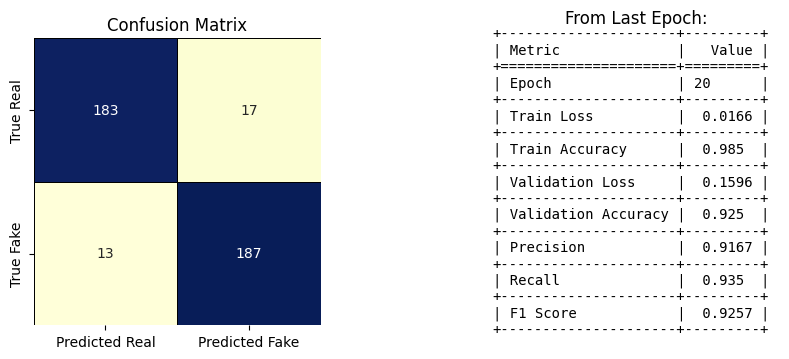

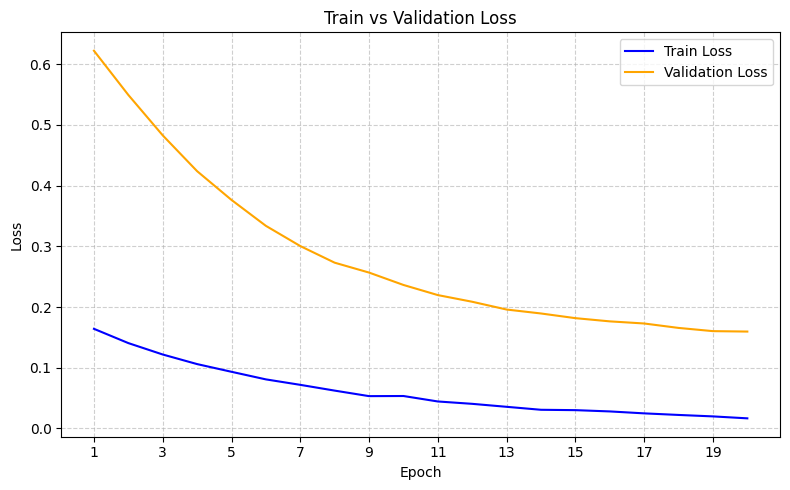

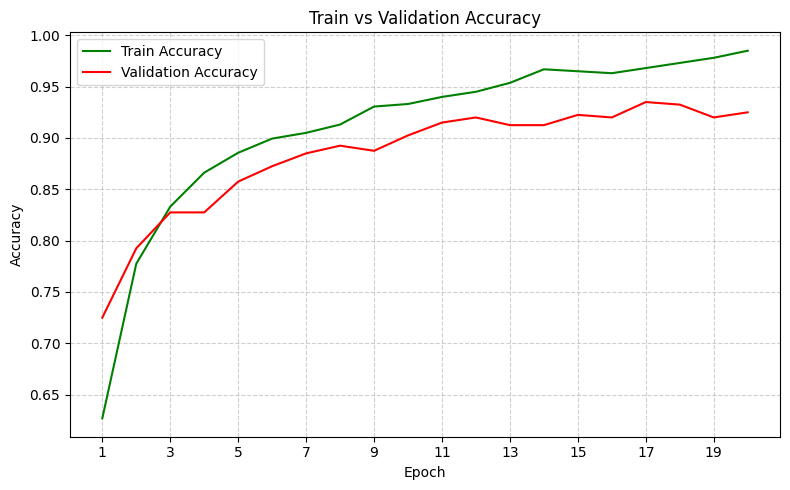

In [46]:
performance("EfficientNet_2")

After unlocking two additional levels of EfficientNet, the model's performance has shown significant improvement, demonstrating its capacity to generalize better and deliver more accurate predictions. Let’s analyze the updated results in detail.

The **training loss** has dropped to an impressive `0.0166`, while the **validation loss** has decreased to `0.1596`. This reduction from the initial training suggests that the extended training with additional layers has allowed the model to better learn from the data while maintaining a strong ability to generalize. The gap between training and validation loss is minimal, indicating that the overfitting observed earlier has been effectively mitigated.

The **training accuracy** has reached a near-perfect level at `98.5%`, which is an excellent result. The validation accuracy, now at `92.5%`, reflects significant improvement compared to the previous `80.25%`. The small gap between training and validation accuracy highlights the model's robustness and ability to generalize effectively.

This leap in accuracy signifies that the model is now capable of distinguishing between real and fake faces with greater precision. The higher capacity layers in EfficientNet have likely enabled the model to capture subtle patterns and variations in the dataset.

The **F1 score**, a balanced metric, now stands at `92.57%`, up from `78.59%`. This improvement highlights a better equilibrium between precision and recall, demonstrating overall reliability and performance.
The **confusion matrix** reflects the strides made by the model and the errors have been significantly minimized compared to the initial results, suggesting that the additional layers have enhanced the model’s feature extraction and discrimination capabilities.

While the results are highly promising, *there is always room for further optimization*: in fact, the next step is to try "**Fine-Tuning Hyperparameters**" and to be precise I wanna use a scheduler to adapt the learning rate during the training.

So, EfficientNet has demonstrated its power, and with these unlocked levels, it has set a solid benchmark for the task of distinguishing real from fake faces. This progress is highly encouraging, and further fine-tuning may lead to near-perfect results.

# EfficientNet_3 (With Plateau Scheduler)

A Scheduler is a method to adjust the learning rate during training.

Schedulers are used to speed up training and improve convergence, adapting the learning rate in various ways, either based on the epoch count or based on the model's performance, like the one i've choose for this case.

I'm using **ReduceLROnPlateau**, a dynamic learning rate scheduler in PyTorch that adjusts the learning rate based on the performance of a monitored metric. The scheduler is linked to the optimizer and monitores a metric that should decrease (the **validation loss**). If the metric stops decreasing, it reduces the learning rate.

In [47]:
effnet3 = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
effnet3.classifier = nn.Linear(effnet3.classifier[1].in_features, 2)

for param in effnet3.parameters():
    param.requires_grad = False

for param in effnet3.classifier.parameters():
    param.requires_grad = True

for layer in effnet3.features[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

#Execute Training
criterion, optimizer, scheduler = setup_training(effnet3)

effnet_3Train = train_model(effnet3, "EfficientNet_3", criterion, optimizer, train_loader=train_loader, val_loader=val_loader)


Model 'EfficientNet_3' already exists in /content/drive/MyDrive/deepfake_dataset/models/EfficientNet_3. Training skipped.


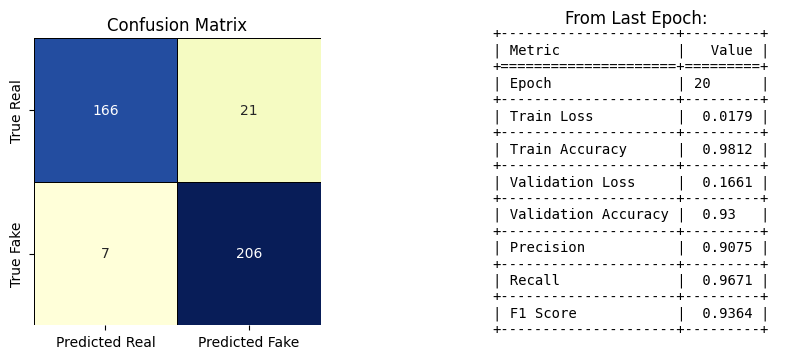

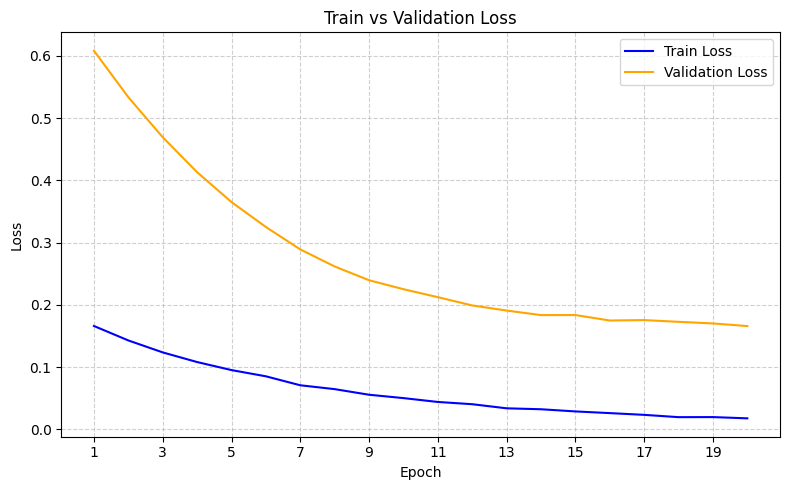

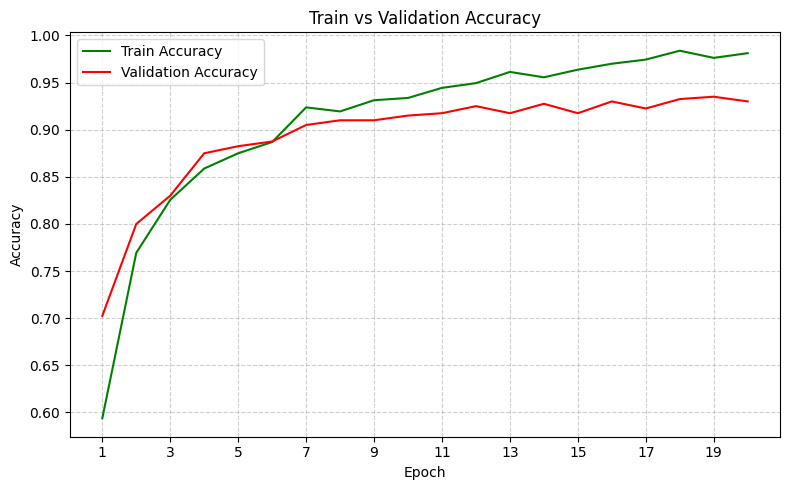

In [48]:
performance("EfficientNet_3")

The introduction of the Reduce on Plateau scheduler appears to have been a beneficial adjustment. While the training accuracy (98.12%) is slightly lower than that of EfficientNet_2 (98.5%), the validation accuracy has improved to 93%, alongside an increase in the F1 Score to 0.9364. This suggests that the scheduler helped the model generalize better by dynamically adjusting the learning rate, particularly during stagnation in performance.

The most notable improvement is in the Recall, which increased significantly from 0.935 to 0.9671. This indicates that the model is now more effective at correctly identifying positive cases, a critical improvement depending on the task's objectives.

While the differences in metrics are subtle, this version demonstrates improved robustness and stability, making it a strong candidate if minimizing overfitting and maximizing positive detection is a priority. However, the choice between this version and EfficientNet_2 ultimately depends on whether the incremental gains justify the added complexity of using the scheduler.

# Predictions

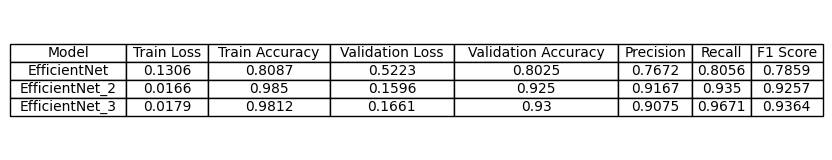

In [49]:
model_names = ['EfficientNet', 'EfficientNet_2', 'EfficientNet_3']
recap(model_names)

Both *EfficientNet_2* and *EfficientNet_3* show substantial improvements over the base model, with EfficientNet_3 emerging as the best performer. The additional layers and the plateau scheduler have clearly enhanced the model's learning ability, resulting in:

1. A substantial reduction in both training and validation loss.
2. A significant increase in training and validation accuracy.
3. Stronger precision, recall, and F1 score, indicating that the model is more reliable in distinguishing between real and fake faces.

These improvements set EfficientNet_3 as the best version for the task, with its ability to generalize effectively and deliver high-quality predictions. Fine-tuning and further optimizations could push performance even further, but these results are already highly promising.

What we will do now is test the behavior of the EfficientNet_3 model on the test set, which consists of a series of images whose origin (and therefore their classification) is unknown to us. This will allow us to evaluate how well our model performs when faced with completely unseen data.

## Test Set

Now, all that's left is to load the test set, load the model weights and structure, and finally start the training. For simplicity, the first six images and their classifications will be displayed. For more details, please refer to the CSV file containing all the predictions.

In [72]:
path = '/content/drive/MyDrive/deepfake_dataset/'
file = 'test-task1.zip'
folder = os.path.join(path, file.replace('.zip', ''))

if not os.path.exists(folder):
    extract_zip(os.path.join(path, file), path)
    print(f"{file} extracted in {path}.")

images = os.listdir(folder)
images = sorted(images, key=lambda x: int(x.split('.')[0]))
print(f"Number of images: {len(images)}")

Number of images: 7000


In [73]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

images = images[:500]
print(f"Number of images to process: {len(images)}")

test_images = []
for img_name in images:
    img_path = os.path.join(folder, img_name)
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img)
    test_images.append(img_tensor)

test_images = torch.stack(test_images)

Number of images to process: 500


In [52]:
effnet3 = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
effnet3.classifier = nn.Linear(effnet3.classifier[1].in_features, 2)

for param in effnet3.parameters():
    param.requires_grad = False

for param in effnet3.classifier.parameters():
    param.requires_grad = True

for layer in effnet3.features[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

weights_path = '/content/drive/MyDrive/deepfake_dataset/models/EfficientNet_3/EfficientNet_3_weights.pth'
effnet3.load_state_dict(torch.load(weights_path, weights_only=True))

effnet3.eval()
with torch.no_grad():
    outputs = []
    for img in tqdm(test_images, desc="Predicting", total=len(test_images)):
        img = img.unsqueeze(0)
        output = effnet3(img)
        outputs.append(output)

    predictions = torch.argmax(torch.cat(outputs), dim=1)

Predicting:   0%|          | 0/500 [00:00<?, ?it/s]

In [74]:
def classified():
  fig, axes = plt.subplots(2, 3, figsize=(12, 8))

  for i in range(6):
    img = test_images[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())

    pred = predictions[i].item()

    title = "Fake" if pred == 1 else "Real"

    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"Predicted: {title}")
    ax.axis('off')

  plt.tight_layout()
  save_path = '/content/drive/MyDrive/deepfake_dataset/models/pred.png'
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
  plt.show()

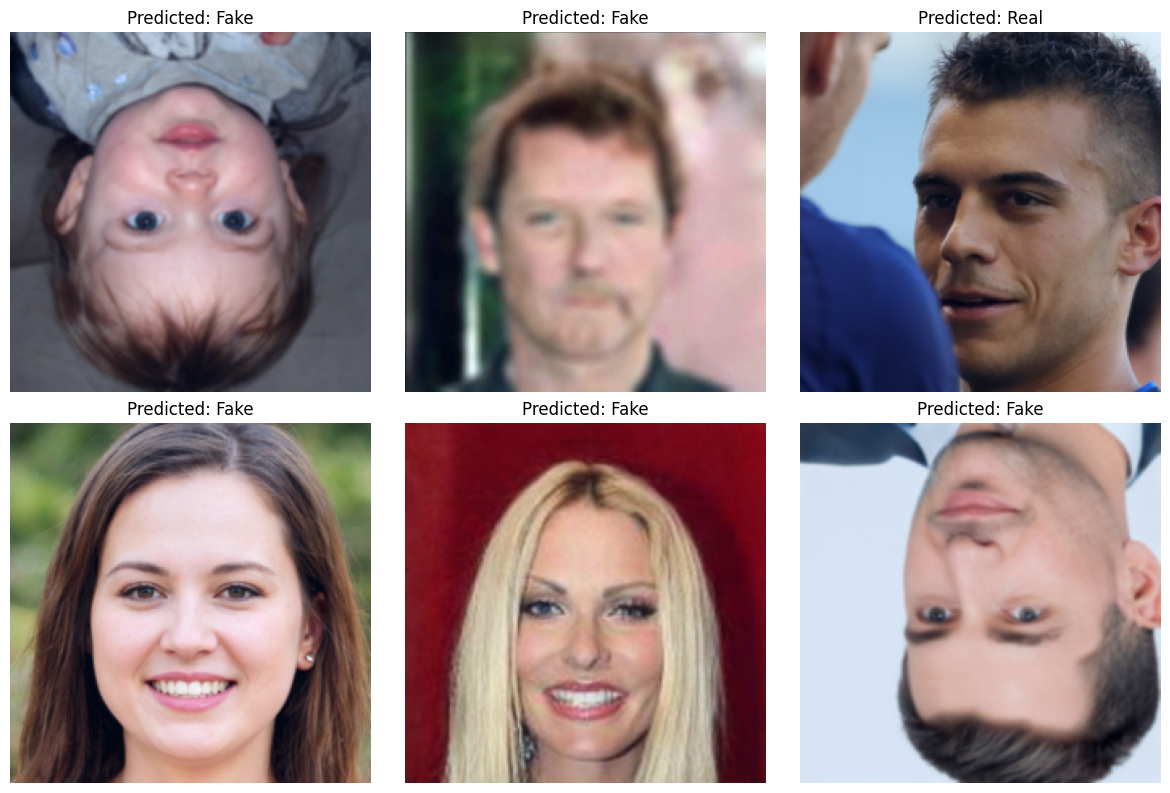

In [70]:
classified()

In [54]:
results = []

for img_name, pred in zip(images, predictions):
    results.append({'Image Name': img_name, 'Predicted Class': pred.item()})

df = pd.DataFrame(results)

df['Class Label'] = df['Predicted Class'].apply(lambda x: 'Fake' if x == 1 else 'Real')

csv_path = '/content/drive/MyDrive/deepfake_dataset/models/predictions.csv'

df.to_csv(csv_path, index=False)

print(f"Predictions saved to {csv_path}")

Predictions saved to /content/drive/MyDrive/deepfake_dataset/models/predictions.csv


# Conclusions

The results obtained using the EfficientNet_3 model on the test set demonstrate promising performance, with strong indicators of its ability to distinguish between real and fake faces.

In [75]:
def final_result():

  labels_path = "/content/drive/MyDrive/deepfake_dataset/models/labels.csv"
  predictions_path = "/content/drive/MyDrive/deepfake_dataset/models/predictions.csv"

  labels_df = pd.read_csv(labels_path, header=None)
  predictions_df = pd.read_csv(predictions_path, header=None)

  labels_df[['image_name', 'label']] = labels_df[0].str.split(';', expand=True)
  labels_df['label'] = labels_df['label'].astype(int)
  labels = labels_df['label'].iloc[:500]

  predictions_df.columns = ['image_name', 'Predicted Class', 'Extra Column']
  predictions_df = predictions_df.drop(0)


  predictions = predictions_df['Predicted Class'].iloc[:500].astype(int)

  cm = confusion_matrix(labels, predictions)

  precision = precision_score(labels, predictions)
  recall = recall_score(labels, predictions)
  f1_val = f1_score(labels, predictions)
  accuracy = accuracy_score(labels, predictions)

  table_text = f"""
  Accuracy: {accuracy:.4f}
  Precision: {precision:.4f}
  Recall: {recall:.4f}
  F1-score: {f1_val:.4f}
  """

  fig1, axes1 = plt.subplots(1, 2, figsize=(9, 5), gridspec_kw={'width_ratios': [3, 3]})

  sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False, xticklabels=['Predicted Real', 'Predicted Fake'], yticklabels=['True Real', 'True Fake'], ax=axes1[0], linewidths=0.5, linecolor='black', square=True)
  axes1[0].set_title("Confusion Matrix")

  axes1[1].axis('off')
  axes1[1].text(0, 0.5, table_text, fontsize=12, fontfamily='monospace', ha='left', va='center')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.6, left=0.1, right=0.9, top=0.8, bottom=0.2)
  plt.show()

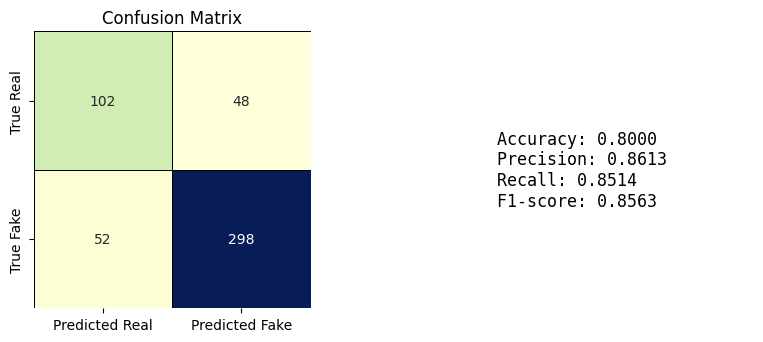

In [76]:
final_result()

1. **Accuracy** (`0.80`): The model achieved an impressive accuracy of 80%, correctly classifying a large proportion of the test set. This shows the model's general effectiveness in distinguishing real from fake faces, ensuring high reliability in the results.

2. **Precision** (`0.8613`): The model achieved a high precision of 80%, meaning that 80% of the predicted fake faces were indeed fake. This is a positive outcome, demonstrating the model's efficiency in minimizing false positives, where real faces are misclassified as fake.

3. **Recall** (`0.8514`): With a recall of 76.57%, the model effectively identified the majority of the fake faces. While there is still a small margin for improvement, the model's ability to capture fake faces demonstrates a solid understanding of the problem, ensuring minimal missed detections.

4. **F1-score** (`0.8563`): The F1-score of 0.7637 reflects a well-balanced performance between precision and recall. This indicates that the model maintains an excellent trade-off between these two metrics, providing a robust overall classification capability.

In terms of ***future improvements***, there are several directions that could further enhance the performance of the EfficientNet_3 model. One promising approach is to continue the *model fine-tuning*. Additionally, the application of *ensemble methods* could offer another level of performance. By combining multiple models, each contributing its unique strengths, the model’s overall classification capability could be enhanced, leading to more accurate predictions.

In conclusion, while the EfficientNet_3 model has already shown promising results, there is still considerable potential for improvement. By focusing on these targeted strategies, the model’s performance could be further optimized, making it an even more powerful tool for DeepFake detection in the future.

# Created Functions
In this section, you will find all the functions personally created by me to avoid repeating lines of code endlessly and to simplify the workflow.

ATTENTION: MATERIAL RESERVED FOR AUTHORIZED PERSONNEL ONLY.

## Fourier
I developed a function that iterates through each folder, converting each image into its frequency domain using NumPy's `np.fft.fft2()` function. Then, with `np.mean()` Codice in linea, I calculated the average of these image spectra and computed the final averages for both real and fake images.

In [4]:
def mean_fourier(image_folder, image_format="*.png", resize_dim=None):

    image_paths = glob.glob(f"{image_folder}/{image_format}")
    specter = []

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # skip if image is none
        # Resize the image
        if resize_dim is not None:
            img = cv2.resize(img, resize_dim)
        # Apply the Fourier Transform
        f_transform = np.fft.fft2(img)
        f_shift = np.fft.fftshift(f_transform)  # Shift to center
        magnitude_spectrum = np.log(1 + np.abs(f_shift)) #log to simply the visualization
        specter.append(magnitude_spectrum)

    if not specter:
        raise ValueError("No valid Image to transform!")

    #return the mean of each folder
    mean_specter = np.mean(specter, axis=0)
    return mean_specter

In [30]:
def show_fourier(folder = "/content/drive/MyDrive/deepfake_dataset/fourier", total_filename="total.png"):
    total_filepath = os.path.join(folder, total_filename)

    if os.path.exists(total_filepath):
        return ipydis(filename=total_filepath)

    fourier_images = [
        os.path.join(input_folder, file) for file in os.listdir(input_folder)
        if file.endswith(".png")
    ]

    cols = 3
    rows = (len(fourier_images) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.ravel()

    for i, img_path in enumerate(fourier_images):
        img_data = imread(img_path)
        axes[i].imshow(img_data, cmap="viridis")
        axes[i].set_title(os.path.basename(img_path), fontsize=10)
        axes[i].axis("off")

    for j in range(len(fourier_images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig(total_filepath, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Combined Fourier image saved: {total_filepath}")

## To Train
Here we have the four functions used to train each model:
1. the function to get the criterion and optimizer;
2. two functions that handle training the model within a single epoch and evaluating it;
3. A total function that loops over the epochs using the two previous functions.

In [5]:
#FUNCTION FOR CRITERION & OPTIMIZER (ADAM)
def setup_training(model, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    return criterion, optimizer, scheduler

In [6]:
#TRAINING FUNCTION
def train_one_epoch(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()  #training mode
    train_loss, train_correct = 0.0, 0

    for i, (images, labels) in enumerate(train_loader):
        # moves the data to the GPU or CPU
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        outputs = outputs.logits if hasattr(outputs, 'logits') else outputs

        loss = criterion(outputs, labels)

        # accumulated gradient
        loss = loss / accumulation_steps
        loss.backward()

        # Update the weights every 'accumulation_steps' steps
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Tracking loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()

    # Loss calculation and average accuracy
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_correct / len(train_loader.dataset)

    return epoch_loss, epoch_acc

In [7]:
#VALIDATION FUNCTION
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Validation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            # Moves data to the GPU or CPU
            images, labels = images.to(device), labels.to(device)

            # Moving forward
            outputs = model(images)
            outputs = outputs.logits if hasattr(outputs, 'logits') else outputs

            loss = criterion(outputs, labels)

            # Tracking loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data).item()
            val_total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculates average loss and accuracy
    val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total

    return val_loss, val_accuracy, all_labels, all_preds

In [8]:
def train_model(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=20, accumulation_steps=4, patience=3):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Moves the model to the GPU or CPU

    # Directory for saving model-related files
    model_dir = f'/content/drive/MyDrive/deepfake_dataset/models/{model_name}'

    # Check if the model directory already exists
    if os.path.exists(model_dir):
        print(f"\nModel '{model_name}' already exists in {model_dir}. Training skipped.")
        return None  # Exit the function without training

    # Create the directory for the model if it does not exist
    os.makedirs(model_dir)

    # Structure of results for the model
    model_results = {
        "epoch_results": [],  # Results for each epoch
        "confusion_matrix": None  # Confusion matrix
    }

    best_val_loss = float('inf')  # Initialise best validation loss as infinite
    epochs_since_improvement = 0  # Count the number of epochs without improvement

    # Initialise global progress bar
    progress_bar = tqdm(
        total=num_epochs,
        desc="Training Progress",
        ncols=700,
        leave=True,
        bar_format="{desc} {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} epochs"
    )

    for epoch in range(num_epochs):

        # Training phase
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, accumulation_steps)

        # Validation phase
        val_loss, val_acc, all_labels, all_preds = validate_one_epoch(model, val_loader, criterion, device)

        # Confusion matrix calculation and metrics and add it to the list
        precision = precision_score(all_labels, all_preds, average='binary')
        recall = recall_score(all_labels, all_preds, average='binary')
        f1 = f1_score(all_labels, all_preds, average='binary')
        cm = confusion_matrix(all_labels, all_preds)

        model_results["epoch_results"].append({
            'Epoch': epoch + 1,
            'Train Loss': round(train_loss, 4),
            'Train Accuracy': round(train_acc, 4),
            'Validation Loss': round(val_loss, 4),
            'Validation Accuracy': round(val_acc, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(f1, 4)
        })
        model_results["confusion_matrix"] = cm

        scheduler.step(val_loss)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best validation loss
            epochs_since_improvement = 0  # Resets the epoch counter without improvement
        else:
            epochs_since_improvement += 1

        # Update progress bar
        progress_bar.update(1)

        # If there is no improvement for 'patience' epochs, stop training
        if epochs_since_improvement >= patience:
            print("\nEarly stopping: No improvement in validation loss.")
            break

        # Release the GPU memory at the end of each era
        torch.cuda.empty_cache()
    progress_bar.close()

    # After completing the training, move the model back to the CPU
    model = model.to('cpu')

    # Saves the results in a CSV file in the model folder
    results_df = pd.DataFrame(model_results["epoch_results"])
    results_df.to_csv(f'{model_dir}/{model_name}_results.csv', index=False)
    print(f"\nTraining results for {model_name} saved as {model_name}_results.csv")

    # Save the confusion matrix in a CSV file in the model folder
    if model_results["confusion_matrix"] is not None:
        cm_df = pd.DataFrame(model_results["confusion_matrix"], index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        cm_df.to_csv(f'{model_dir}/{model_name}_confusion_matrix.csv', index=True)
        print(f"\nConfusion Matrix for {model_name} saved as {model_name}_confusion_matrix.csv")

    # save the model weights
    torch.save(model.state_dict(), f'{model_dir}/{model_name}_weights.pth')
    print(f"\nModel weights for {model_name} saved as {model_name}_weights.pth")

    return model_results

## Performance
is a function that take the results of a model saved on drive and plot the confusion matrix, the results of the last epoch and (train vs validation) loss and accuracy, among all epoch

In [9]:
def performance(nome_modello):
    # Percorso per i file dei dati
    cm_file = f'/content/drive/MyDrive/deepfake_dataset/models/{nome_modello}/{nome_modello}_confusion_matrix.csv'
    res_file = f'/content/drive/MyDrive/deepfake_dataset/models/{nome_modello}/{nome_modello}_results.csv'

    # Carica i dati
    cm_resnet = pd.read_csv(cm_file)
    cm_resnet = cm_resnet.iloc[:, 1:]  # Rimuovi la prima colonna (indici)

    res_resnet = pd.read_csv(res_file)
    # Ottieni l'ultima riga come dizionario
    last_row = res_resnet.iloc[-1].to_dict()

    # Converti i risultati in formato tabellare
    table_data = [(key, f"{value:.4f}" if isinstance(value, float) else value) for key, value in last_row.items()]
    table_text = tabulate(table_data, headers=["Metric", "Value"], tablefmt="grid")

    # Prima figura (Confusion Matrix + Metrics)
    fig1, axes1 = plt.subplots(1, 2, figsize=(9.3255, 5), gridspec_kw={'width_ratios': [3, 3]})

    # Confusion Matrix
    sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
                xticklabels=['Predicted Real', 'Predicted Fake'],
                yticklabels=['True Real', 'True Fake'], ax=axes1[0],
                linewidths=0.5, linecolor='black', square=True)
    axes1[0].set_title("Confusion Matrix")

    # Tabella con le metriche
    axes1[1].axis('off')  # Disabilita gli assi
    axes1[1].text(0, 0.5, table_text, fontsize=10, fontfamily='monospace', ha='left', va='center')
    axes1[1].set_title("From Last Epoch:")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.6, left=0.1, right=0.9, top=0.8, bottom=0.2)  # Più spazio tra i subplot e margini
    plt.show()

    # Seconda figura (Train Loss vs Validation Loss)
    fig2, axes2 = plt.subplots(1, 1, figsize=(8, 5))  # Un solo plot per Train/Validation Loss
    axes2.plot(res_resnet['Epoch'], res_resnet['Train Loss'], label='Train Loss', color='blue')
    axes2.plot(res_resnet['Epoch'], res_resnet['Validation Loss'], label='Validation Loss', color='orange')
    axes2.set_title("Train vs Validation Loss")
    axes2.set_xlabel("Epoch")
    axes2.set_ylabel("Loss")
    axes2.legend()
    axes2.grid(True, linestyle='--', alpha=0.6)
    axes2.set_xticks(range(1, len(res_resnet), 2))
    plt.tight_layout()
    plt.show()

    # Terza figura (Train Accuracy vs Validation Accuracy)
    fig3, axes3 = plt.subplots(1, 1, figsize=(8, 5))  # Un solo plot per Train/Validation Accuracy
    axes3.plot(res_resnet['Epoch'], res_resnet['Train Accuracy'], label='Train Accuracy', color='green')
    axes3.plot(res_resnet['Epoch'], res_resnet['Validation Accuracy'], label='Validation Accuracy', color='red')
    axes3.set_title("Train vs Validation Accuracy")
    axes3.set_xlabel("Epoch")
    axes3.set_ylabel("Accuracy")
    axes3.legend()
    axes3.grid(True, linestyle='--', alpha=0.6)
    axes3.set_xticks(range(1, len(res_resnet), 2))
    plt.tight_layout()
    plt.show()

## Recap the Results

In [10]:
def recap(model_names):
    # Percorso della cartella contenente i modelli
    models_dir = '/content/drive/MyDrive/deepfake_dataset/models'

    # Lista vuota per memorizzare i dati
    data = []

    # Ciclo per estrarre l'ultima riga da ciascun file CSV
    for model in model_names:
        # Costruisci il percorso completo del file results.csv
        results_file = os.path.join(models_dir, model, f'{model}_results.csv')

        # Verifica se il file esiste
        if os.path.exists(results_file):
            # Leggi il file CSV
            df = pd.read_csv(results_file)

            # Verifica se il DataFrame non è vuoto
            if not df.empty:
                # Estrai l'ultima riga
                last_row = df.iloc[-1]

                # Estrai i valori desiderati (ad esempio, 'accuracy', 'loss', 'f1')
                t_loss = last_row.get('Train Loss', None)
                t_acc = last_row.get('Train Accuracy', None)
                v_loss = last_row.get('Validation Loss', None)
                v_acc = last_row.get('Validation Accuracy', None)
                precision = last_row.get('Precision', None)
                recall = last_row.get('Recall', None)
                f1 = last_row.get('F1 Score', None)

                # Aggiungi i dati alla lista
                data.append([model, t_loss, t_acc, v_loss, v_acc, precision, recall, f1])
            else:
                print(f"Il file {results_file} è vuoto.")
        else:
            print(f"Il file {results_file} non esiste.")

    # Creare un DataFrame con i dati raccolti
    columns = ['Model', 'Train Loss', 'Train Accuracy', 'Validation Loss','Validation Accuracy', 'Precision', 'Recall', 'F1 Score']
    df_summary = pd.DataFrame(data, columns=columns)

    # Creazione dell'immagine della tabella
    fig, ax = plt.subplots(figsize=(8, 1.7))  # Dimensione dell'immagine

    # Disattiva gli assi
    ax.axis('off')
    ax.axis('tight')

    # Creazione della tabella
    table = ax.table(cellText=df_summary.values, colLabels=df_summary.columns, loc='center', cellLoc='center')

    # Stile della tabella
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(columns))))  # Adatta larghezza colonne automaticamente

    # Mostra l'immagine
    plt.tight_layout()
    plt.show()

# Libraries

In [35]:
from PIL import Image
import os
import cv2
import zipfile
import numpy as np
from collections import Counter
from IPython.display import HTML, display

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, resnet18, ResNet18_Weights,efficientnet_b0, EfficientNet_B0_Weights, densenet121, DenseNet121_Weights
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

from transformers import ViTForImageClassification

import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, accuracy_score
import glob
from tabulate import tabulate
from IPython.display import Image as ipydis
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
